In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 150)
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
torch.set_default_dtype(torch.float64)


import seaborn as sns
import matplotlib.pyplot as plt

import mplhep as hep
hep.style.use("CMS")
import matplotlib.colors as mcolors
import os
torch.set_default_dtype(torch.float64)

In [3]:
filecode = 'xgb_En'
resultcode = '2in1'
iacode = 'x14x5_long'
# occode = 'InfAwar_test_rmvd_ubld_40'

oc_xgb = np.load(f'/vols/cms/hw423/Data/Week14/octest_{filecode}.npy')
OC_xgb = torch.tensor(oc_xgb,dtype = torch.float64)

oc_ia = np.load(f'/vols/cms/hw423/Data/Week14/Post/octest_{filecode}_{iacode}.npy')
OC_ia = torch.tensor(oc_ia,dtype = torch.float64)

Lb = pd.read_pickle('/vols/cms/hw423/Data/Week14/Label_En.pkl')
dfy = pd.get_dummies(Lb)
dfw = pd.read_pickle('/vols/cms/hw423/Data/Week14/weight.pkl')
true = torch.tensor(np.array(dfy).astype(int))
labels = torch.tensor(np.array(Lb))
label = torch.tensor(np.array(dfy),dtype = torch.float64)


weight = torch.tensor(np.array(dfw),dtype = torch.float64)

folder_name = f"/vols/cms/hw423/Week14/A_Post_trains/plots/{filecode}_{resultcode}"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"folder'{folder_name}' has made")
else:
    print(f"folder '{folder_name}' already exists")

col = ['$\gamma\gamma$-0','$\gamma\gamma$-1','ggH-0','ggH-1','qqH-0','qqH-1','WH-0','WH-1','ZH-0','ZH-1','ttH-0','ttH-1','tH-0','tH-1']
col_s = ['$\gamma\gamma$','ggH','qqH','WH','ZH','ttH','tH']

folder '/vols/cms/hw423/Week14/A_Post_trains/plots/xgb_En_2in1' already exists


In [10]:

def smooth_argmax(tensor, dim=-1, temperature=1.0):
    softmax_tensor =F.softmax(tensor / temperature, dim=dim)
    return softmax_tensor
def confusion_matrix(OC,label,weight):
    label_w = 138000*weight.unsqueeze(1)*label
    pred_matrix = smooth_argmax(OC,temperature=.0000001,dim=1)
    # pred_matrix_w = weight.unsqueeze(1)*pred_matrix
    confusion_matrix = torch.matmul(pred_matrix.t(),label_w)[2:,:]
    return confusion_matrix

def confusion_matrix_s(OC,label,weight):
    label_w = 138000*weight.unsqueeze(1)*label
    pred_matrix = smooth_argmax(OC,temperature=.0000001,dim=1)
    # pred_matrix_w = weight.unsqueeze(1)*pred_matrix
    confusion_matrix = torch.matmul(pred_matrix.t(),label_w)[1:,:]
    return confusion_matrix

def nll(theta1,cm):
    O = torch.sum(cm,dim=1)
    theta0 = torch.ones(2)
    theta = torch.cat([theta0,theta1])
    return -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))

def plot_confusion_matrix_s(cm, title='Confusion Matrix', cmap='blues', filename='confusion_matrix',**kwargs):
    fig, ax = plt.subplots(figsize=(10,8))
    plot_params = {k: v for k, v in kwargs.items()}
    mask = abs(cm) < 0.01
    annot = np.where(mask, "", np.round(cm, 2).astype(str))
    cmap = sns.color_palette(cmap, as_cmap=True)
    cmap_colors = ['white'] + list(cmap(np.linspace(0, 1, cmap.N)))
    custom_cmap = mcolors.ListedColormap(cmap_colors)
    boundaries = [-0.01, 0.01] + list(np.linspace(0.01, 1, cmap.N))
    norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=len(boundaries))

    ax = sns.heatmap(cm, annot=annot,fmt='', cmap=custom_cmap,norm=norm,**plot_params) 
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.set_xticklabels(col_s[1:],rotation = 90)
    ax.set_yticklabels(col_s[1:],rotation = 0)
    fig.savefig(f'{folder_name}/{filename}.pdf', bbox_inches='tight')

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap='blues', filename='confusion_matrix',**kwargs):
    fig, ax = plt.subplots(figsize=(16,12))
    plot_params = {k: v for k, v in kwargs.items()}
    mask = abs(cm) < 0.01
    annot = np.where(mask, "", np.round(cm, 2).astype(str))
    cmap = sns.color_palette(cmap, as_cmap=True)
    cmap_colors = ['white'] + list(cmap(np.linspace(0, 1, cmap.N)))
    custom_cmap = mcolors.ListedColormap(cmap_colors)
    boundaries = [-0.01, 0.01] + list(np.linspace(0.01, 1, cmap.N))
    norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=len(boundaries))

    ax = sns.heatmap(cm, annot=annot,fmt='', cmap=custom_cmap,norm=norm,**plot_params) 
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.set_xticklabels(col[2:],rotation = 90)
    ax.set_yticklabels(col[2:],rotation = 0)
    fig.savefig(f'{folder_name}/{filename}.pdf', bbox_inches='tight')


def plot_correlation_matrix(cm, title='Correlation Matrix', cmap='blues', filename='confusion_matrix',**kwargs):
    max = cm.max().numpy()
    min = cm.min().numpy()
    cm = pd.DataFrame(cm.numpy())
    fig, ax = plt.subplots(figsize=(16,12))
    plot_params = {k: v for k, v in kwargs.items()}
    mask = abs(cm) < 0.01

    annot = np.where(mask, "", np.round(cm, 2).astype(str))
    cmapp = sns.color_palette('Reds', as_cmap=True)
    cmapn = sns.color_palette('Blues_r', as_cmap=True)
    cmap_colors =  list(cmapn(np.linspace(0, 1, 200)))+ ['white'] + list(cmapp(np.linspace(0, 1, 200))) 
    custom_cmap = mcolors.ListedColormap(cmap_colors)
    boundaries = list(np.linspace(-0.8, -0.01, 200)) + [-0.01, 0.01] + list(np.linspace(0.01, 1, 200))
    norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=len(boundaries) )

    ax = sns.heatmap(cm, annot=annot,fmt='',norm=norm, cmap=custom_cmap,**plot_params) 
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.set_xticklabels(col[2:],rotation = 90)
    ax.set_yticklabels(col[2:],rotation = 0)
    fig.savefig(f'{folder_name}/{filename}.pdf', bbox_inches='tight')

def plot_correlation_matrix_s(cm, title='Correlation Matrix', cmap='blues', filename='confusion_matrix',**kwargs):
    max = cm.max().numpy()
    min = cm.min().numpy()
    cm = pd.DataFrame(cm.numpy())
    fig, ax = plt.subplots(figsize=(10,8))
    plot_params = {k: v for k, v in kwargs.items()}
    mask = abs(cm) < 0.01

    annot = np.where(mask, "", np.round(cm, 2).astype(str))
    cmapp = sns.color_palette('Reds', as_cmap=True)
    cmapn = sns.color_palette('Blues_r', as_cmap=True)
    cmap_colors =  list(cmapn(np.linspace(0, 1, 200)))+ ['white'] + list(cmapp(np.linspace(0, 1, 200))) 
    custom_cmap = mcolors.ListedColormap(cmap_colors)
    boundaries = list(np.linspace(-1, -0.01, 200)) + [-0.01, 0.01] + list(np.linspace(0.01, 1, 200))
    norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=len(boundaries) )

    ax = sns.heatmap(cm, annot=annot,fmt='',norm=norm, cmap=custom_cmap,**plot_params) 
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.set_xticklabels(col_s[1:],rotation = 90)
    ax.set_yticklabels(col_s[1:],rotation = 0)
    fig.savefig(f'{folder_name}/{filename}.pdf', bbox_inches='tight')

def nll(theta1,cm):
    O = torch.sum(cm,dim=1)
    theta0 = torch.ones(2)
    theta = torch.cat([theta0,theta1])
    return -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))

def nll_s(theta1,cm):
    O = torch.sum(cm,dim=1)
    theta0 = torch.ones(1)
    theta = torch.cat([theta0,theta1])
    theta = theta.repeat_interleave(2)
    return -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))


def hess_to_tensor(H):
    hess_elements = []
    for i in range(len(H)):
        for j in range(len(H)):
            hess_elements.append(H[i][j].reshape(1))
    return torch.cat(hess_elements).reshape(len(H),len(H))

def Correlation(cm):
    hess = torch.func.hessian(nll,0)(torch.ones(12),cm)
    H = hess_to_tensor(hess)
    I = torch.inverse(H)
    sigma = torch.diag(I)**0.5
    Cor = torch.zeros(12,12)
    for i in range(12):
        for j in range(12):
            Cor[i,j] = I[i,j]/(sigma[i]*sigma[j])
    return Cor
def Correlation_s(cm):
    hess = torch.func.hessian(nll_s,0)(torch.ones(6),cm)
    H = hess_to_tensor(hess)
    I = torch.inverse(H)
    sigma = torch.diag(I)**0.5
    Cor = torch.zeros(6,6)
    for i in range(6):
        for j in range(6):
            Cor[i,j] = I[i,j]/(sigma[i]*sigma[j])
    return Cor


In [5]:
sumsation = torch.zeros(14,7)
for i in range(7):
    sumsation[2*i,i]=1
    sumsation[2*i+1,i]=1
label_s =label@sumsation
OC_ia_s= smooth_argmax(OC_ia,temperature=0.01)@sumsation
OC_xgb_s= smooth_argmax(OC_xgb,temperature=0.01)@sumsation

In [6]:
cm_xgb = confusion_matrix(OC_xgb,label,weight).to(torch.float64)
cm_xgb_s = confusion_matrix(OC_xgb_s,label_s,weight).to(torch.float64)
cm_ia = confusion_matrix_s(OC_ia,label,weight).to(torch.float64)
cm_ia_s = confusion_matrix_s(OC_ia_s,label_s,weight).to(torch.float64)

tensor([[ 1.0000, -0.5206, -0.0046, -0.0114,  0.0287,  0.0085],
        [-0.5206,  1.0000, -0.0250, -0.0061, -0.1639, -0.0657],
        [-0.0046, -0.0250,  1.0000, -0.2558, -0.0049, -0.0311],
        [-0.0114, -0.0061, -0.2558,  1.0000, -0.0015, -0.0023],
        [ 0.0287, -0.1639, -0.0049, -0.0015,  1.0000, -0.2900],
        [ 0.0085, -0.0657, -0.0311, -0.0023, -0.2900,  1.0000]])

In [7]:

# def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues, filename='confusion_matrix',**kwargs):
#     fig, ax = plt.subplots(figsize=(10,8))
#     plot_params = {k: v for k, v in kwargs.items()}
#     ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap,**plot_params)  # Using '.2f' for floating point format
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('True')
#     ax.set_title(title)
#     ax.set_xticklabels(col[1:])
#     ax.set_yticklabels(col[1:])
#     fig.savefig(f'{folder_name}/{filename}.pdf', bbox_inches='tight')

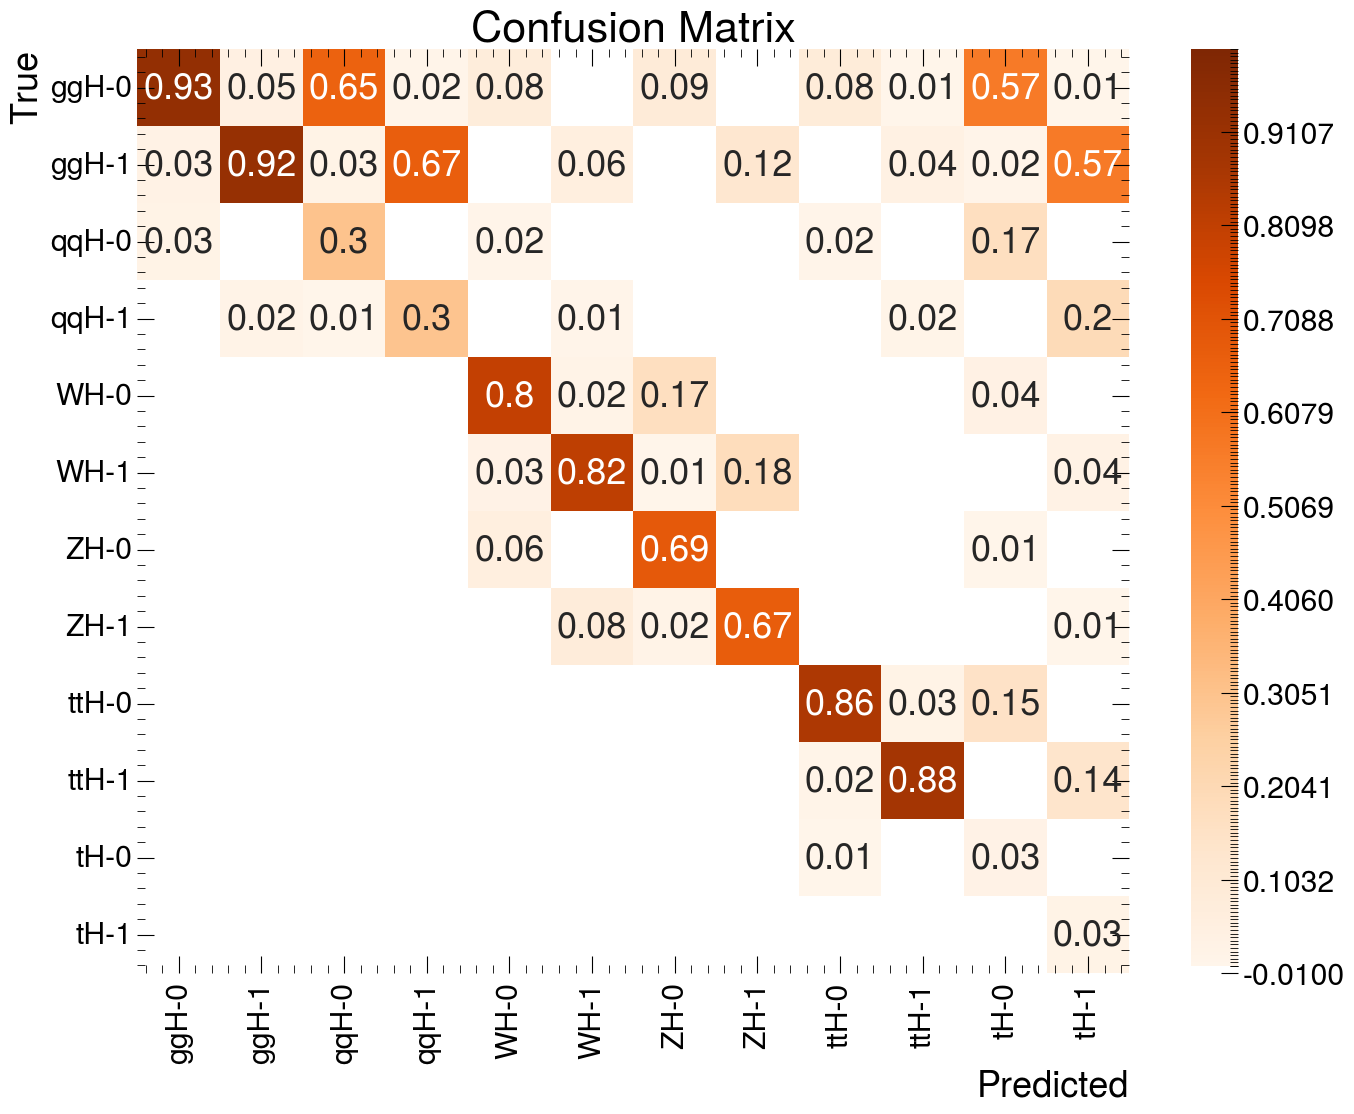

In [11]:
#original XGB cm
cm_w = pd.DataFrame(cm_xgb[:,2:].detach().numpy()).T
CM = []
for i in range(12):
    cl = cm_w.iloc[:,i]/cm_w.iloc[:,i].sum()
    CM.append(cl)
cm = pd.DataFrame(CM).T
plot_confusion_matrix(cm, cmap='Oranges',filename='Confusion_matrix_xgb')

#Post IA-trainned
# cm_w = pd.DataFrame(cm_ia_s[:,1:].detach().numpy()).T
# CM = []
# for i in range(6):
#     cl = cm_w.iloc[:,i]/cm_w.iloc[:,i].sum()
#     CM.append(cl)
# cm = pd.DataFrame(CM).T
# plot_confusion_matrix_s(cm, cmap='Oranges',filename='Confusion_matrix_ia')

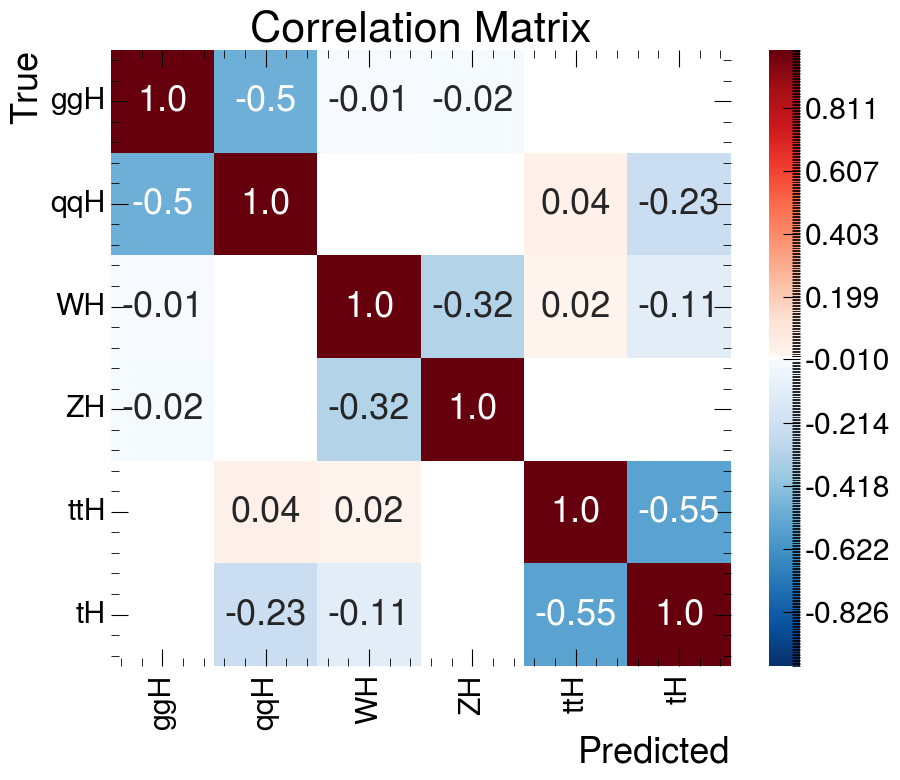

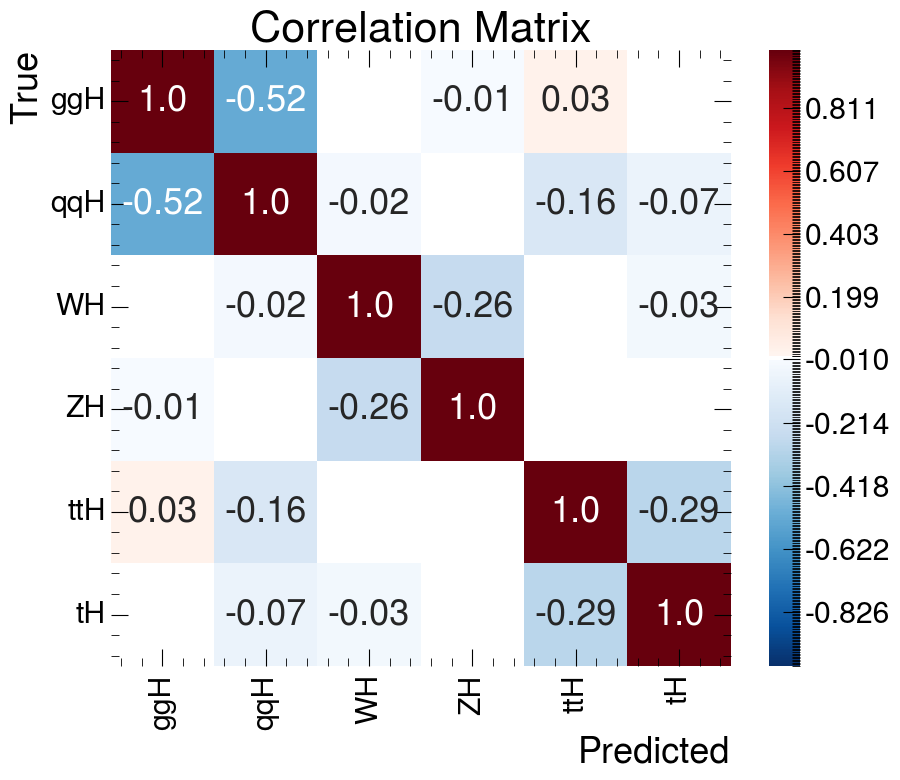

In [114]:
plot_correlation_matrix_s(Correlation_s(cm_xgb),filename='Correlation_xgb')
plot_correlation_matrix_s(Correlation_s(cm_ia),filename='Correlation_ia')

tensor(-0.5645)

In [25]:
y = data.iloc[:,-14:].idxmax(axis=1)

In [36]:
label = (y.astype('float')*2).astype('int')

In [42]:
label.to_pickle('/vols/cms/hw423/Data/Week14/Label_En.pkl')

In [12]:
1e4

10000.0

In [17]:
oc.argmax(dim=1).unique()

tensor([ 0,  2,  3,  4, 10, 11, 12, 13])

In [115]:
[]
train_hp = {
    "lr":0.001,
    "batch_size":10000,
    "N_epochs":200,
    "seed":0,
}
nodes = [14,14]


In [72]:
filecode = 'InfA_xgb_AJF'
oc = np.load(f'/vols/cms/hw423/Data/Week14/octest_{filecode}.npy')
Lb = pd.read_pickle('/vols/cms/hw423/Data/Week14/Label.pkl')
dfy = pd.get_dummies(Lb)
dfw = pd.read_pickle('/vols/cms/hw423/Data/Week14/weight.pkl')
true = torch.tensor(np.array(dfy).astype(int),dtype = torch.float64)

labels = torch.tensor(np.array(Lb),dtype = torch.float64)
OC = torch.tensor(oc,dtype = torch.float64)
weight = torch.tensor(np.array(dfw),dtype = torch.float64)*138000
label = torch.tensor(np.array(dfy),dtype = torch.float64)




In [104]:
octest = torch.load('/vols/cms/hw423/Data/Week14/oc_test_ia.pt')

In [107]:
octest

tensor([1, 0, 0,  ..., 1, 3, 1])

In [118]:

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(train_hp['seed'])

def hess_to_tensor(H):
    hess_elements = []
    for i in range(len(H)):
        for j in range(len(H)):
            hess_elements.append(H[i][j].reshape(1))
    return torch.cat(hess_elements).reshape(len(H),len(H))



class Net(nn.Module):
    def __init__(self, n_features=14, nodes=[14,14], output_nodes=14,temp=0.0001):
        super(Net, self).__init__()
        self.temperature = temp
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes) - 1):
            linear_layer = nn.Linear(n_nodes[i], n_nodes[i+1])

            with torch.no_grad():
                linear_layer.weight.copy_(torch.eye(n_nodes[i+1], n_nodes[i]))
            with torch.no_grad():
                linear_layer.bias.zero_()
            self.layers.append(linear_layer)
            
            self.layers.append(nn.ReLU())
        


    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # return F.softmax(out)
        return out
        
    def set_temperature(self, temp):
        self.temperature = temp

def smooth_argmax(tensor, dim=-1, temperature=1.0):
    softmax_tensor =F.softmax(tensor / temperature, dim=dim)
    return softmax_tensor
def confusion_matrix(OC,label,weight,model):
    label_w = weight.unsqueeze(1)*label
    pred_matrix = smooth_argmax(model(OC),temperature=.01,dim=1)
    confusion_matrix = torch.matmul(pred_matrix.t(),label_w)[1:,:]
    return confusion_matrix
def nll(theta1,OC,label,weight,model):
    cm = confusion_matrix(OC,label,weight,model)
    O = torch.sum(cm,dim=1)
    theta0 = torch.ones(1)
    theta = torch.cat([theta0,theta1])
    return -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))
def InfAwareLoss(input,label,weight, model,theta_init = torch.ones(6)):
    theta = torch.tensor(theta_init)
    hess = torch.func.hessian(nll,0)(theta,input,label,weight,model)
    H = hess_to_tensor(hess)
    I = torch.inverse(H)
    return torch.trace(I)**(1/2)

In [119]:
model = Net()

tensor([[0.1746, 0.7657, 0.0568,  ..., 0.0000, 0.0000, 0.0000],
        [0.2268, 0.0913, 0.2167,  ..., 0.0000, 0.0000, 0.0000],
        [0.3032, 0.1777, 0.4739,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0755, 0.3976, 0.4302,  ..., 0.0000, 0.0000, 0.0000],
        [0.0008, 0.0010, 0.0035,  ..., 0.0000, 0.0000, 0.0000],
        [0.0165, 0.1697, 0.7421,  ..., 0.0000, 0.0000, 0.0000]])

In [124]:
OCext = torch.cat([OC,torch.zeros(OC.size())],dim=1)
label

In [125]:
model(OCext)

tensor([[0.1746, 0.7657, 0.0568,  ..., 0.0000, 0.0000, 0.0000],
        [0.2268, 0.0913, 0.2167,  ..., 0.0000, 0.0000, 0.0000],
        [0.3032, 0.1777, 0.4739,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0755, 0.3976, 0.4302,  ..., 0.0000, 0.0000, 0.0000],
        [0.0008, 0.0010, 0.0035,  ..., 0.0000, 0.0000, 0.0000],
        [0.0165, 0.1697, 0.7421,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

In [126]:
cm = confusion_matrix(octest,label,weight,model)
cm_w = pd.DataFrame(cm[:,1:].detach().numpy()).T
CM = []
for i in range(6):
    cl = cm_w.iloc[:,i]/cm_w.iloc[:,i].sum()
    CM.append(cl)
cm = pd.DataFrame(CM).T

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2914423x7 and 14x14)

<Axes: >

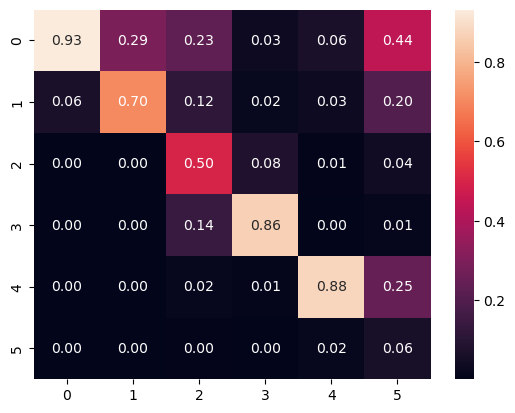

In [109]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='.2f')

In [71]:
torch.eye(7,100)@torch.eye(100,7)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])